In [95]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [96]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128  # stride
BATCH_SIZE = 128  # batch
EPOCHS = 100  # epoch
LEARNING_RATE = 0.001  # lr
PROJ_DIM = 128  # embedding dimension

In [97]:
datapath = "../../../data/MobiFall_Dataset/" 

In [98]:
adl_activities = ['STD', 'WAL', 'JOG', 'JUM', 
                  'STU', 'STN', 'SCH', 'CSI', 'CSO'] 
fall_activities = ['FOL', 'FKL', 'BSC', 'SDL'] 

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

In [99]:
adl_fall_subjects = list(range(1, 12))
print("ADL+Fall subjects:", adl_fall_subjects)

fall_only_subjects = list(range(12, 22)) + list(range(29, 32))
print("Fall-only subjects:", fall_only_subjects)

train_split = adl_fall_subjects[:8] + fall_only_subjects[:9]    
val_split = adl_fall_subjects[8:10] + fall_only_subjects[9:11]    
test_split = adl_fall_subjects[10:] + fall_only_subjects[11:]  

print ()
print ("=====" * 10)
print()

print(f"Train subjects (ADL+Fall): {adl_fall_subjects[:8]}")
print(f"Train subjects (Fall only): {fall_only_subjects[:9]}")
print(f"Total train subjects: {train_split}\n")

print(f"Val subjects (ADL+Fall): {adl_fall_subjects[8:10]}")
print(f"Val subjects (Fall only): {fall_only_subjects[9:11]}")
print(f"Total val subjects: {val_split}\n")

print(f"Test subjects (ADL+Fall): {adl_fall_subjects[10:]}")
print(f"Test subjects (Fall only): {fall_only_subjects[11:]}")
print(f"Total test subjects: {test_split}\n")

print(f"Total number of train subjects: {len(train_split)}")
print(f"Total number of validation subjects: {len(val_split)}")
print(f"Total number of test subjects: {len(test_split)}")

ADL+Fall subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Fall-only subjects: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 31]


Train subjects (ADL+Fall): [1, 2, 3, 4, 5, 6, 7, 8]
Train subjects (Fall only): [12, 13, 14, 15, 16, 17, 18, 19, 20]
Total train subjects: [1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Val subjects (ADL+Fall): [9, 10]
Val subjects (Fall only): [21, 29]
Total val subjects: [9, 10, 21, 29]

Test subjects (ADL+Fall): [11]
Test subjects (Fall only): [30, 31]
Total test subjects: [11, 30, 31]

Total number of train subjects: 17
Total number of validation subjects: 4
Total number of test subjects: 3


In [100]:
def read_sensor_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
        data_start = 0
        for i, line in enumerate(lines):
            if line.strip() == '@DATA':  # data tag finding
                data_start = i + 1
                break
        
        ###### parsing part
        data_lines = []
        for line in lines[data_start:]:
            if line.strip():  
                try:
                    values = [float(val.strip()) for val in line.strip().split(',')]
                    data_lines.append(values)
                except ValueError:
                    continue
        
        df = pd.DataFrame(data_lines) 
        df = df.ffill()  # forward fill
        df = df.bfill()  # backward fill
        return df

In [101]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length].T
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [102]:
'''
    TRAIN DATA PREPARING PART
    ONLY "ADL"
'''

train_data_normal = []  
train_labels_normal = [] 

from sklearn.preprocessing import StandardScaler

train_data_normal = []
train_labels_normal = []

for subject_id in tqdm(adl_fall_subjects):  # only using ADL+Fall subjects
    subject_dir = os.path.join(datapath, f"sub{subject_id}")
    adl_dir = os.path.join(subject_dir, "ADL")
        
    for activity in adl_activities:  ####### only ADL 
        activity_dir = os.path.join(adl_dir, activity)
            
        acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
        acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
        
        for acc_file in acc_files:
            trial_num = acc_file.split('_')[-1]
            gyro_file = os.path.join(activity_dir, f"{activity}_gyro_{subject_id}_{trial_num}")
                
            try:
                acc_data = read_sensor_file(acc_file)
                acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                
                gyro_data = read_sensor_file(gyro_file)
                gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                
                merged_data = pd.merge_asof(
                    acc_data.sort_values('timestamp'),
                    gyro_data.sort_values('timestamp'),
                    on='timestamp',
                    direction='nearest',
                    tolerance=1e7
                )
                
                merged_data = merged_data.fillna(0)
                sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                         'gyro_x', 'gyro_y', 'gyro_z']].values
                
                activity_labels = np.full(len(sensor_data), label2id[activity])
                
                windows_data, windows_labels = split_sequences(
                    sensor_data, activity_labels, 
                    WINDOW_LENGTH, STRIDE
                )
                
                if windows_data is not None and len(windows_data) > 0:
                    train_data_normal.append(windows_data)
                    train_labels_normal.append(windows_labels)
                    
            except Exception as e: 
                print(f"Error processing file {acc_file}: {e}")
                
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.15it/s]

# of windows: 5760
data shape: (5760, 6, 256)
shape: (5760,)
{0: 5760}


In [103]:
'''
    TRAIN DATA PREPARING PART
    ADL + FALL
'''

test_data = []
test_labels = []

all_subjects = adl_fall_subjects + fall_only_subjects
for subject_id in tqdm(all_subjects):
    subject_dir = os.path.join(datapath, f"sub{subject_id}")
    
    # Process ADL activities
    adl_dir = os.path.join(subject_dir, "ADL")
    if os.path.exists(adl_dir):
        for activity in adl_activities:
            activity_dir = os.path.join(adl_dir, activity)
            if not os.path.exists(activity_dir):
                continue

            acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
            acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
            
            for acc_file in acc_files:
                trial_num = acc_file.split('_')[-1]
                gyro_file = os.path.join(activity_dir, f"{activity}_gyro_{subject_id}_{trial_num}")
                
                if not os.path.exists(gyro_file):
                    continue
                    
                try:
                    acc_data = read_sensor_file(acc_file)
                    acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                    
                    gyro_data = read_sensor_file(gyro_file)
                    gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                    
                    merged_data = pd.merge_asof(
                        acc_data.sort_values('timestamp'),
                        gyro_data.sort_values('timestamp'),
                        on='timestamp',
                        direction='nearest',
                        tolerance=1e7
                    )
                    
                    merged_data = merged_data.fillna(0)
                    sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                             'gyro_x', 'gyro_y', 'gyro_z']].values
                    
                    activity_labels = np.full(len(sensor_data), label2id[activity])
                    windows_data, windows_labels = split_sequences(sensor_data, activity_labels)
                    
                    if windows_data is not None and len(windows_data) > 0:
                        test_data.append(windows_data)
                        test_labels.append(windows_labels)
                        
                except Exception as e: 
                    print(f"Error processing file {acc_file}: {e}")
    
    falls_dir = os.path.join(subject_dir, "FALLS")
    if os.path.exists(falls_dir):
        for activity in fall_activities:
            activity_dir = os.path.join(falls_dir, activity)
            if not os.path.exists(activity_dir):
                continue
                
            acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
            acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
            
            for acc_file in acc_files:
                trial_num = acc_file.split('_')[-1]
                gyro_file = os.path.join(activity_dir, f"{activity}_gyro_{subject_id}_{trial_num}")
                
                if not os.path.exists(gyro_file):
                    continue
                    
                try:
                    acc_data = read_sensor_file(acc_file)
                    acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                    
                    gyro_data = read_sensor_file(gyro_file)
                    gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                    
                    merged_data = pd.merge_asof(
                        acc_data.sort_values('timestamp'),
                        gyro_data.sort_values('timestamp'),
                        on='timestamp',
                        direction='nearest',
                        tolerance=1e7
                    )
                    
                    merged_data = merged_data.fillna(0)
                    sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                             'gyro_x', 'gyro_y', 'gyro_z']].values
                    
                    activity_labels = np.full(len(sensor_data), label2id[activity])
                    windows_data, windows_labels = split_sequences(sensor_data, activity_labels)
                    
                    if windows_data is not None and len(windows_data) > 0:
                        test_data.append(windows_data)
                        test_labels.append(windows_labels)
                        
                except Exception as e: 
                    print(f"Error processing file {acc_file}: {e}")

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print(f"# of windows: {len(test_data)}")
print(f"data shape: {test_data.shape}")
print(f"shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 24/24 [00:10<00:00,  2.19it/s]


# of windows: 7193
data shape: (7193, 6, 256)
shape: (7193,)
{0: 5760, 1: 1433}


In [104]:
train_data_shape = train_data_normal.shape
test_data_shape = test_data.shape

train_data_2d = train_data_normal.reshape(-1, train_data_normal.shape[-1])
test_data_2d = test_data.reshape(-1, test_data.shape[-1])

scaler = StandardScaler()
train_data_2d = scaler.fit_transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_normal = train_data_2d.reshape(train_data_shape)
test_data = test_data_2d.reshape(test_data_shape)

In [105]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:] 

train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (5760, 6, 3)
train data - gyro shape: (5760, 6, 253)
test data - accel shape: (7193, 6, 3)
test data - gyro shape: (7193, 6, 253)
# of training batches: 45
# of test batches: 57


------

In [106]:
class Encoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
        super(Encoder, self).__init__()
        self.use_skip = use_skip
        self.num_encoders = num_encoders
        
        for i in range(num_encoders):
            setattr(self, f'conv1_{i}', layers.Conv1D(filters=out_feat*3, 
                                                      kernel_size=7, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool1_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv2_{i}', layers.Conv1D(filters=out_feat*2, 
                                                      kernel_size=5, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool2_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv3_{i}', layers.Conv1D(filters=out_feat*1, 
                                                      kernel_size=3, padding='same', 
                                                      activation='relu'))
    
    def call(self, x, training=False):
        for i in range(self.num_encoders):
            if self.use_skip and i > 0:
                identity = x
            
            x = getattr(self, f'conv1_{i}')(x)
            x = getattr(self, f'maxpool1_{i}')(x)
            x = getattr(self, f'conv2_{i}')(x)
            x = getattr(self, f'maxpool2_{i}')(x)
            x = getattr(self, f'conv3_{i}')(x)
            
            if self.use_skip and i > 0:
                x = x + identity
        
        return tf.reduce_mean(x, axis=1)

In [107]:
class CAGE(Model):
    def __init__(self, n_feat=6, proj_dim=128):
        super(CAGE, self).__init__()
        self.proj_dim = proj_dim
        
        self.enc_A = Encoder(n_feat, 64)
        self.enc_G = Encoder(n_feat, 64)
        
        if self.proj_dim > 0:
            self.proj_A = layers.Dense(proj_dim, use_bias=False)
            self.proj_G = layers.Dense(proj_dim, use_bias=False)
        
        self.temperature = tf.Variable(0.1, trainable=True)
    
    def call(self, x_accel, x_gyro, return_feat=False, training=False):
        f_accel = self.enc_A(x_accel, training=training)
        f_gyro = self.enc_G(x_gyro, training=training)
        
        if self.proj_dim > 0:
            e_accel = self.proj_A(f_accel)
            e_gyro = self.proj_G(f_gyro)
        else:
            e_accel = f_accel
            e_gyro = f_gyro
        
        e_accel = tf.math.l2_normalize(e_accel, axis=1)
        e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
        sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
        if return_feat:
            return sim_matrix, (e_accel, e_gyro)
        
        return sim_matrix

In [108]:
model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

In [109]:
# @tf.function
# def contrastive_loss(logits):
#     """NT-Xent Loss"""
#     batch_size = tf.shape(logits)[0]
    
#     labels = tf.eye(batch_size) # diagonal matrix 
    
#     '''
#         loss calculating using CrossEntropy
#     '''
#     loss = tf.keras.losses.categorical_crossentropy(
#         labels, 
#         tf.nn.softmax(logits, axis=-1), 
#         from_logits=False
#     )
    
#     return tf.reduce_mean(loss)

def contrastive_loss(sim_matrix):
    batch_size = tf.shape(sim_matrix)[0]
    
    labels = tf.eye(batch_size)
    
    loss_1 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=1),
        from_logits=False
    )
    
    loss_2 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=0),
        from_logits=False
    )
    
    total_loss = (loss_1 + loss_2) / 2
    return tf.reduce_mean(total_loss)

In [110]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
        loss = contrastive_loss(sim_matrix)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

----

In [111]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 253), dtype=tf.float64, name=None))>


In [112]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss = train_step(model, optimizer, acc_batch, gyro_batch)  
        epoch_losses.append(loss.numpy())
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print (f"mean value of loss : {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print (f"best loss achieved : {best_loss:.4f}")

        
print("END THE LEARNING")
print(f"final best loss: {best_loss:.4f}")

Epoch 1/100: 100%|██████████████████████████████| 45/45 [00:02<00:00, 16.28it/s]


mean value of loss : 4.6622
best loss achieved : 4.6622


Epoch 2/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 29.77it/s]


mean value of loss : 4.3325
best loss achieved : 4.3325


Epoch 3/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 28.93it/s]


mean value of loss : 4.2356
best loss achieved : 4.2356


Epoch 4/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 30.37it/s]


mean value of loss : 4.0657
best loss achieved : 4.0657


Epoch 5/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 28.63it/s]


mean value of loss : 4.0007
best loss achieved : 4.0007


Epoch 6/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 28.78it/s]


mean value of loss : 4.0340


Epoch 7/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 28.59it/s]


mean value of loss : 3.8342
best loss achieved : 3.8342


Epoch 8/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 29.18it/s]


mean value of loss : 3.6012
best loss achieved : 3.6012


Epoch 9/100: 100%|██████████████████████████████| 45/45 [00:01<00:00, 26.12it/s]


mean value of loss : 3.3010
best loss achieved : 3.3010


Epoch 10/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 24.87it/s]


mean value of loss : 3.4319


Epoch 11/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.49it/s]


mean value of loss : 3.2643
best loss achieved : 3.2643


Epoch 12/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 23.44it/s]


mean value of loss : 3.1749
best loss achieved : 3.1749


Epoch 13/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.12it/s]


mean value of loss : 2.9854
best loss achieved : 2.9854


Epoch 14/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 30.66it/s]


mean value of loss : 3.1468


Epoch 15/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.10it/s]


mean value of loss : 2.9916


Epoch 16/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.53it/s]


mean value of loss : 2.9000
best loss achieved : 2.9000


Epoch 17/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.53it/s]


mean value of loss : 2.8873
best loss achieved : 2.8873


Epoch 18/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 31.36it/s]


mean value of loss : 2.7663
best loss achieved : 2.7663


Epoch 19/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.04it/s]


mean value of loss : 2.9774


Epoch 20/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.79it/s]


mean value of loss : 2.7288
best loss achieved : 2.7288


Epoch 21/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.49it/s]


mean value of loss : 2.6891
best loss achieved : 2.6891


Epoch 22/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.03it/s]


mean value of loss : 2.8229


Epoch 23/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.84it/s]


mean value of loss : 2.7622


Epoch 24/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 31.51it/s]


mean value of loss : 2.5900
best loss achieved : 2.5900


Epoch 25/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 31.18it/s]


mean value of loss : 2.7478


Epoch 26/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.03it/s]


mean value of loss : 2.9134


Epoch 27/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 30.21it/s]


mean value of loss : 2.6041


Epoch 28/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.83it/s]


mean value of loss : 2.6540


Epoch 29/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 32.36it/s]


mean value of loss : 2.5376
best loss achieved : 2.5376


Epoch 30/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.26it/s]


mean value of loss : 2.5575


Epoch 31/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.55it/s]


mean value of loss : 2.4245
best loss achieved : 2.4245


Epoch 32/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.80it/s]


mean value of loss : 2.4819


Epoch 33/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.29it/s]


mean value of loss : 2.4584


Epoch 34/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.34it/s]


mean value of loss : 2.2981
best loss achieved : 2.2981


Epoch 35/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 24.63it/s]


mean value of loss : 2.3555


Epoch 36/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 24.31it/s]


mean value of loss : 2.2507
best loss achieved : 2.2507


Epoch 37/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.80it/s]


mean value of loss : 2.2571


Epoch 38/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.66it/s]


mean value of loss : 2.4593


Epoch 39/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.49it/s]


mean value of loss : 2.2300
best loss achieved : 2.2300


Epoch 40/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.69it/s]


mean value of loss : 2.5142


Epoch 41/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 30.10it/s]


mean value of loss : 2.3671


Epoch 42/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.60it/s]


mean value of loss : 2.1588
best loss achieved : 2.1588


Epoch 43/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 24.76it/s]


mean value of loss : 2.2754


Epoch 44/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.50it/s]


mean value of loss : 2.3515


Epoch 45/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.09it/s]


mean value of loss : 2.2739


Epoch 46/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.01it/s]


mean value of loss : 2.3762


Epoch 47/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 32.72it/s]


mean value of loss : 2.2789


Epoch 48/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.73it/s]


mean value of loss : 2.2509


Epoch 49/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.53it/s]


mean value of loss : 2.1781


Epoch 50/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.96it/s]


mean value of loss : 2.2240


Epoch 51/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.75it/s]


mean value of loss : 2.2357


Epoch 52/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.51it/s]


mean value of loss : 2.1726


Epoch 53/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.44it/s]


mean value of loss : 2.2863


Epoch 54/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.79it/s]


mean value of loss : 2.2035


Epoch 55/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.41it/s]


mean value of loss : 2.1056
best loss achieved : 2.1056


Epoch 56/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 34.38it/s]


mean value of loss : 2.2923


Epoch 57/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 35.24it/s]


mean value of loss : 2.0402
best loss achieved : 2.0402


Epoch 58/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 32.98it/s]


mean value of loss : 1.9999
best loss achieved : 1.9999


Epoch 59/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 24.68it/s]


mean value of loss : 2.0154


Epoch 60/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.24it/s]


mean value of loss : 2.0224


Epoch 61/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 33.53it/s]


mean value of loss : 2.0301


Epoch 62/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.35it/s]


mean value of loss : 1.9260
best loss achieved : 1.9260


Epoch 63/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.05it/s]


mean value of loss : 2.1945


Epoch 64/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.13it/s]


mean value of loss : 2.0074


Epoch 65/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.59it/s]


mean value of loss : 2.2016


Epoch 66/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 30.35it/s]


mean value of loss : 2.1186


Epoch 67/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.98it/s]


mean value of loss : 1.9305


Epoch 68/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.98it/s]


mean value of loss : 1.8815
best loss achieved : 1.8815


Epoch 69/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 30.46it/s]


mean value of loss : 2.1268


Epoch 70/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.51it/s]


mean value of loss : 1.9764


Epoch 71/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.49it/s]


mean value of loss : 2.1080


Epoch 72/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.83it/s]


mean value of loss : 1.9025


Epoch 73/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.22it/s]


mean value of loss : 1.9250


Epoch 74/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.74it/s]


mean value of loss : 1.8796
best loss achieved : 1.8796


Epoch 75/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.91it/s]


mean value of loss : 2.0179


Epoch 76/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.33it/s]


mean value of loss : 1.9185


Epoch 77/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.94it/s]


mean value of loss : 2.0079


Epoch 78/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.23it/s]


mean value of loss : 1.9140


Epoch 79/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.61it/s]


mean value of loss : 1.8453
best loss achieved : 1.8453


Epoch 80/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.08it/s]


mean value of loss : 2.0066


Epoch 81/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.46it/s]


mean value of loss : 1.8558


Epoch 82/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 23.89it/s]


mean value of loss : 1.7840
best loss achieved : 1.7840


Epoch 83/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 23.09it/s]


mean value of loss : 1.8368


Epoch 84/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.15it/s]


mean value of loss : 1.9021


Epoch 85/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 28.54it/s]


mean value of loss : 1.9414


Epoch 86/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.87it/s]


mean value of loss : 1.8645


Epoch 87/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 27.74it/s]


mean value of loss : 1.8268


Epoch 88/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.94it/s]


mean value of loss : 1.8682


Epoch 89/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 29.79it/s]


mean value of loss : 1.8671


Epoch 90/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 30.75it/s]


mean value of loss : 1.8132


Epoch 91/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 32.39it/s]


mean value of loss : 1.8727


Epoch 92/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 33.61it/s]


mean value of loss : 1.8494


Epoch 93/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 34.53it/s]


mean value of loss : 1.7629
best loss achieved : 1.7629


Epoch 94/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 33.55it/s]


mean value of loss : 1.7545
best loss achieved : 1.7545


Epoch 95/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 32.57it/s]


mean value of loss : 1.8060


Epoch 96/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 30.02it/s]


mean value of loss : 2.1687


Epoch 97/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 26.98it/s]


mean value of loss : 1.8145


Epoch 98/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 25.08it/s]


mean value of loss : 1.9013


Epoch 99/100: 100%|█████████████████████████████| 45/45 [00:01<00:00, 31.43it/s]


mean value of loss : 1.8551


Epoch 100/100: 100%|████████████████████████████| 45/45 [00:01<00:00, 26.87it/s]

mean value of loss : 1.6851
best loss achieved : 1.6851
END THE LEARNING
final best loss: 1.6851


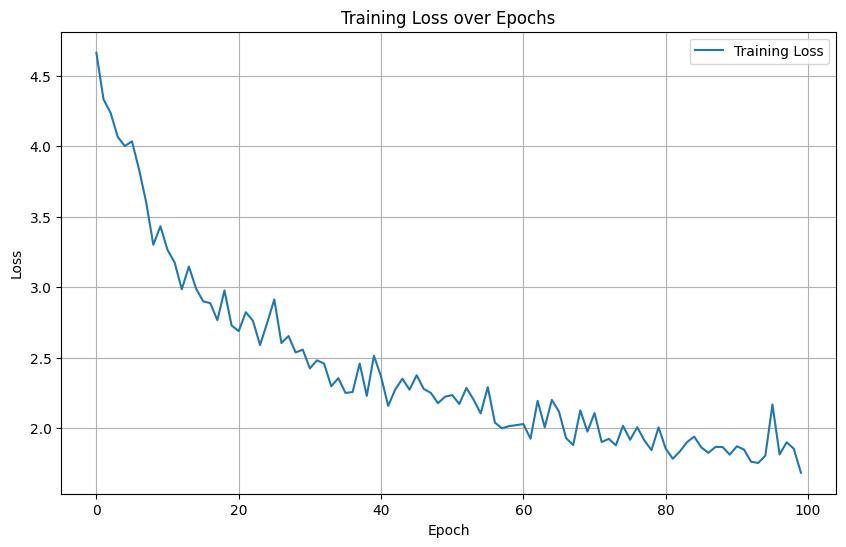

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

----

In [114]:
def compute_similarity_scores(model, data_loader):
    similarities = []
    labels = []
    
    for (acc_batch, gyro_batch), batch_labels in data_loader:
        # get embeddings
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) 
        # get embedding of accel and gyro
        
        # calculate cosine similarity between paired embeddings
        batch_similarities = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        similarities.extend(batch_similarities.numpy())
        labels.extend(batch_labels.numpy())
    
    return np.array(similarities), np.array(labels)

In [115]:
normal_similarities = []
for acc_batch, gyro_batch in tqdm(train_dataset, desc='Computing normal similarities'):
    # train set embedding -> similarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    normal_similarities.extend(sim.numpy())

test_similarities = []
test_pred_labels = []
for (acc_batch, gyro_batch), labels in tqdm(test_dataset, desc='Computing test similarities'):
    # test set embedding -> simiilarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    test_similarities.extend(sim.numpy())
    test_pred_labels.extend(labels.numpy())

Computing test similarities: 100%|██████████████| 57/57 [00:01<00:00, 35.94it/s]


In [122]:
threshold = np.percentile(normal_similarities, 10)

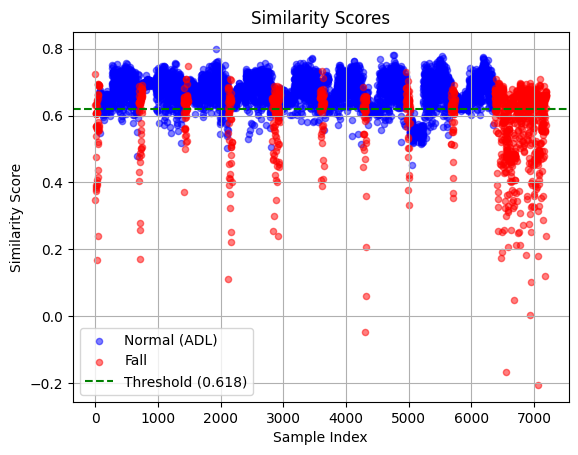

In [123]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.3f})')
# plt.ylim(0.0078100, 0.0078150)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores')
plt.legend()
plt.grid(True)

In [124]:
predictions = [1 if sim < threshold else 0 for sim in test_similarities] 
true_labels = test_pred_labels

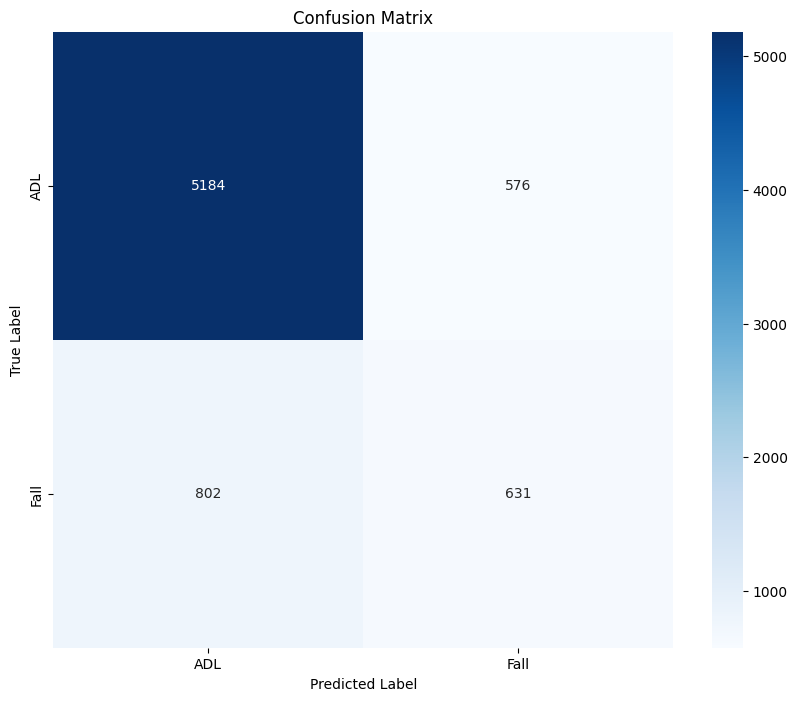

In [125]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
labels = ['ADL', 'Fall']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [126]:
print ("classification report")
print(classification_report(true_labels, predictions, 
                          target_names=['ADL', 'Fall']))

classification report
              precision    recall  f1-score   support

         ADL       0.87      0.90      0.88      5760
        Fall       0.52      0.44      0.48      1433

    accuracy                           0.81      7193
   macro avg       0.69      0.67      0.68      7193
weighted avg       0.80      0.81      0.80      7193



In [127]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
        
        sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        for sim_score, label in zip(sim.numpy(), labels.numpy()):
            if label == 0:  # normal
                normal_similarities.append(sim_score)
            else:  # fall
                fall_similarities.append(sim_score)
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.6706
  Std: 0.0437
  Min: 0.4527
  Max: 0.7991
ADL ind 1 : 0.66996324
ADL ind 2 : 0.6441254
ADL ind 3 : 0.641145
ADL ind 4 : 0.6423162
ADL ind 5 : 0.6389915
ADL ind 6 : 0.62068653
ADL ind 7 : 0.63512874
ADL ind 8 : 0.61449075
ADL ind 9 : 0.63990045
ADL ind 10 : 0.6519058
ADL ind 11 : 0.6567054
ADL ind 12 : 0.65322876
ADL ind 13 : 0.6528282
ADL ind 14 : 0.6653702
ADL ind 15 : 0.6640573
ADL ind 16 : 0.639475
ADL ind 17 : 0.65794224
ADL ind 18 : 0.6534803
ADL ind 19 : 0.6122113
ADL ind 20 : 0.5475985

[ FALL data ]
  Mean: 0.5845
  Std: 0.1084
  Min: -0.2048
  Max: 0.7470
FALL ind 1 : 0.3474272
FALL ind 2 : 0.7256322
FALL ind 3 : 0.6314129
FALL ind 4 : 0.6326001
FALL ind 5 : 0.6355902
FALL ind 6 : 0.47722447
FALL ind 7 : 0.37386084
FALL ind 8 : 0.5652911
FALL ind 9 : 0.5685494
FALL ind 10 : 0.568504
FALL ind 11 : 0.3814603
FALL ind 12 : 0.60467225
FALL ind 13 : 0.6080198
FALL ind 14 : 0.60665005
FALL ind 15 : 0.60823095
FALL ind 16 : 0.39400974
FALL ind 17 : 0.38554